In [20]:
import torch
import h5py
import numpy as np
from torch import nn
from torchvision import datasets
from torchvision.transforms import ToTensor, Lambda
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import pickle
from sklearn.preprocessing import normalize
from scipy.sparse import lil_matrix, csr_matrix, hstack
from tqdm import tqdm
import math

In [21]:
# 변수 선언 block
train_rec_file_list = ["./train_recs/CF_rec_cpl_dim_64.pickle",
                "./train_recs/Graph_rec_cpl_1_2_depth_5.pickle",
                "./train_recs/Graph_rec_cpl_1_4_depth_3.pickle",
                "./train_recs/Graph_rec_cpl_1_8_depth_3.pickle",
                "./train_recs/Graph_rec_cpl_1_8_depth_1.pickle",]

valid_rec_file_list = ["./valid_recs/CF_rec_cpl_dim_64.pickle",
                "./valid_recs/Graph_rec_cpl_1_2_depth_5.pickle",
                "./valid_recs/Graph_rec_cpl_1_4_depth_3.pickle",
                "./valid_recs/Graph_rec_cpl_1_8_depth_3.pickle",
                "./valid_recs/Graph_rec_cpl_1_8_depth_1.pickle",]

train_path = '../Hanseul/Container/train_cpl'

valid_path = './Container/valid_cpl'

state_dict_save_path = "./ensemble_model/ensemble_model_best_cpl.pt"

loss_fig_path = "./ensemble_model/ensemble_cpl_loss.png"
acc_fig_path = "./ensemble_model/ensemble_cpl_acc.png"

epochs = 10

In [22]:
class RecDataset(Dataset):
    def __init__(self, recs_list, answer_dict, query_num, item_num, transform=None, target_transform=None):
        # rec_matrix = [query num, model_num, item_num]
        self.rec_matrix = []
        for i in range(query_num):
            self.rec_matrix.append(lil_matrix((len(rec_file_list), item_num)))
        for i, recs in enumerate(recs_list):
            for query in tqdm(recs.keys()):
                rec = recs[query]
                rec_items, rec_scores = [rec_ for rec_, score in rec], [score for rec_, score in rec]
                rec_scores = normalize(np.array(rec_scores)[:,np.newaxis], axis=0).ravel()
                for item, score in zip(rec_items, rec_scores):
                    self.rec_matrix[query][i, item] = score
        self.labels = answer_dict
        self.transform = transform
        self.target_transform = target_transform
        self.device = "cuda" if torch.cuda.is_available() else "cpu"

    def __len__(self):
        return len(self.rec_matrix)

    def __getitem__(self, idx):
        rec_matrix = self.rec_matrix[idx].toarray()
        label = self.labels[idx]
        if self.transform:
            rec_matrix = self.transform(rec_matrix).to(self.device)
        if self.target_transform:
            label = self.target_transform(label)
        return rec_matrix.to(self.device), label.to(self.device)

In [23]:
class Network(nn.Module):
    def __init__(self, model_len, k=10):
        super(Network, self).__init__()
        self.w1 = torch.nn.Parameter(torch.randn(k, model_len))
        self.w2 = torch.nn.Parameter(torch.randn(1, k))
        
    def forward(self, x):
        #import ipdb; ipdb.set_trace()
        x = x.float()
        x = torch.einsum('nm, bmp -> bnp', self.w1, x)
        x = torch.einsum('nm, bmp -> bnp', self.w2, x).squeeze(1)
        return x

In [24]:
recs_list = []
for rec_file in train_rec_file_list:
    with open(rec_file, 'rb') as f:
        recs = pickle.load(f)
        recs_list.append(recs)

query_num = len(recs_list[0])
item_num = 6714

h5f_valid = h5py.File(train_path, 'r')
answer = h5f_valid['labels_id'][:].astype(np.int64)
h5f_valid.close()

answer_dict = {}
for i, ans in enumerate(answer):
    answer_dict[i] = ans

train_data = RecDataset(recs_list, answer_dict, query_num, item_num, transform=torch.Tensor, target_transform=torch.tensor)
train_dataloader = DataLoader(train_data, batch_size=64, shuffle=True)
###############
recs_list = []
for rec_file in valid_rec_file_list:
    with open(rec_file, 'rb') as f:
        recs = pickle.load(f)
        recs_list.append(recs)

query_num = len(recs_list[0])
item_num = 6714

h5f_valid = h5py.File(valid_path, 'r')
answer = h5f_valid['labels_id'][:].astype(np.int64)
h5f_valid.close()

answer_dict = {}
for i, ans in enumerate(answer):
    answer_dict[i] = ans

test_data = RecDataset(recs_list, answer_dict, query_num, item_num, transform=torch.Tensor, target_transform=torch.tensor)
test_dataloader = DataLoader(test_data, batch_size=64, shuffle=True)

100%|███████████████████████████████████████████████████████████████████████████| 7848/7848 [00:00<00:00, 11748.53it/s]


In [25]:
device = "cuda" if torch.cuda.is_available() else "cpu"
model = Network(len(rec_file_list), k=10).to(device)
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

def train_loop(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    total_loss = 0
    for batch, (X, y) in tqdm(enumerate(dataloader),total=len(dataloader)):
        if batch > 368:
            break
        pred = model(X)
        loss = loss_fn(pred, y)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    avg_loss = total_loss / (batch + 1)
    print(f"Train loss: {avg_loss:>7f}")
    return avg_loss
            
def test_loop(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    test_loss, correct = 0, 0

    with torch.no_grad():
        for X, y in tqdm(dataloader):
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()

    test_loss /= num_batches
    correct /= size
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")
    return test_loss, correct
        
train_loss_lst = []
test_loss_lst = []
test_acc_lst = []
min_test_loss = math.inf
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train_loss = train_loop(train_dataloader, model, loss_fn, optimizer)
    test_loss, test_acc = test_loop(test_dataloader, model, loss_fn)
    train_loss_lst.append(train_loss)
    test_loss_lst.append(test_loss)
    test_acc_lst.append(test_acc)
    print(model.parameters())
    if test_loss < min_test_loss:
        min_test_loss = test_loss
        torch.save(model.state_dict(), state_dict_save_path)
print("Done!")

Epoch 1
-------------------------------


  9%|███████▎                                                                       | 369/3960 [00:07<01:12, 49.74it/s]


Train loss: 9.360023


100%|████████████████████████████████████████████████████████████████████████████████| 123/123 [00:01<00:00, 69.02it/s]


Test Error: 
 Accuracy: 7.5%, Avg loss: 8.480588 

<generator object Module.parameters at 0x000001E697477D60>
Epoch 2
-------------------------------


  9%|███████▎                                                                       | 369/3960 [00:07<01:15, 47.44it/s]


Train loss: 7.808943


100%|████████████████████████████████████████████████████████████████████████████████| 123/123 [00:02<00:00, 54.79it/s]


Test Error: 
 Accuracy: 6.9%, Avg loss: 7.742296 

<generator object Module.parameters at 0x000001E697477C80>
Epoch 3
-------------------------------


  9%|███████▎                                                                       | 369/3960 [00:07<01:15, 47.76it/s]


Train loss: 7.557466


100%|████████████████████████████████████████████████████████████████████████████████| 123/123 [00:02<00:00, 55.18it/s]


Test Error: 
 Accuracy: 7.1%, Avg loss: 7.646355 

<generator object Module.parameters at 0x000001E697477C80>
Epoch 4
-------------------------------


  9%|███████▎                                                                       | 369/3960 [00:07<01:15, 47.76it/s]


Train loss: 7.422416


100%|████████████████████████████████████████████████████████████████████████████████| 123/123 [00:02<00:00, 55.93it/s]


Test Error: 
 Accuracy: 7.1%, Avg loss: 7.589936 

<generator object Module.parameters at 0x000001E697477CF0>
Epoch 5
-------------------------------


  9%|███████▎                                                                       | 369/3960 [00:07<01:17, 46.21it/s]


Train loss: 7.365515


100%|████████████████████████████████████████████████████████████████████████████████| 123/123 [00:02<00:00, 52.45it/s]


Test Error: 
 Accuracy: 7.2%, Avg loss: 7.572202 

<generator object Module.parameters at 0x000001E697477D60>
Epoch 6
-------------------------------


  9%|███████▎                                                                       | 369/3960 [00:07<01:16, 47.14it/s]


Train loss: 7.306827


100%|████████████████████████████████████████████████████████████████████████████████| 123/123 [00:02<00:00, 56.68it/s]


Test Error: 
 Accuracy: 7.3%, Avg loss: 7.561450 

<generator object Module.parameters at 0x000001E697477F90>
Epoch 7
-------------------------------


  9%|███████▎                                                                       | 369/3960 [00:07<01:14, 47.98it/s]


Train loss: 7.297609


100%|████████████████████████████████████████████████████████████████████████████████| 123/123 [00:02<00:00, 54.76it/s]


Test Error: 
 Accuracy: 7.3%, Avg loss: 7.545504 

<generator object Module.parameters at 0x000001E697477B30>
Epoch 8
-------------------------------


  9%|███████▎                                                                       | 369/3960 [00:06<01:07, 53.25it/s]


Train loss: 7.311643


100%|████████████████████████████████████████████████████████████████████████████████| 123/123 [00:01<00:00, 70.05it/s]


Test Error: 
 Accuracy: 7.3%, Avg loss: 7.534576 

<generator object Module.parameters at 0x000001E697477D60>
Epoch 9
-------------------------------


  9%|███████▎                                                                       | 369/3960 [00:05<00:57, 62.23it/s]


Train loss: 7.281052


100%|████████████████████████████████████████████████████████████████████████████████| 123/123 [00:01<00:00, 66.96it/s]


Test Error: 
 Accuracy: 7.3%, Avg loss: 7.522659 

<generator object Module.parameters at 0x000001E697477C80>
Epoch 10
-------------------------------


  9%|███████▎                                                                       | 369/3960 [00:08<01:18, 45.74it/s]


Train loss: 7.274163


100%|████████████████████████████████████████████████████████████████████████████████| 123/123 [00:02<00:00, 55.73it/s]

Test Error: 
 Accuracy: 7.2%, Avg loss: 7.519080 

<generator object Module.parameters at 0x000001E697477CF0>
Done!


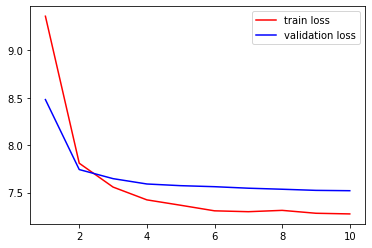

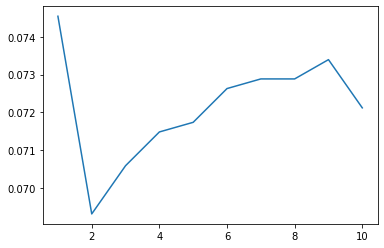

In [26]:
import matplotlib.pyplot as plt
epoch_lst = list(range(1, epochs+1))
plt.plot(epoch_lst, train_loss_lst, 'r', label='train loss')
plt.plot(epoch_lst, test_loss_lst, 'b', label = 'validation loss')
plt.legend()
plt.savefig(loss_fig_path)
plt.show()

plt.plot(epoch_lst, test_acc_lst)
plt.savefig(acc_fig_path)
plt.show()